**Importando bibliotecas necessárias**

In [18]:
import pandas as pd
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_score,  StratifiedKFold, cross_val_predict, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline

**Carregando dados do forms**

In [19]:
df = pd.read_excel('Forms_ConstruConecta.xlsx')

**Pré-processamento dos Dados**

In [20]:
# Realizamos a limpeza e o pré-processamento dos dados, incluindo a remoção de colunas desnecessárias e o tratamento de erros
# Removend colunas que não serão utilizadas
df = df.drop(['Faixa_Etaria', 'Funcionalidade_no_App', 'Índice'], axis=1)

# Tratando erros na coluna 'Realizaria_Reforma'
df['Realizaria_Reforma'] = df['Realizaria_Reforma'].replace('Sim;Não', 'Sim')

**Transformando o tipo da Variável de Resposta para numérico**

In [21]:
#Convertemos a coluna de resposta Usuaria_App de valores categóricos ('Sim' e 'Não') para valores numéricos (1 e 0). Fizemos isso para que o modelo de machine learning possa processar esses dados
# Convertendo resposta para numérico
df['Usuaria_App'] = df['Usuaria_App'].map({'Sim': 1, 'Não': 0})

**Separação de Atributos e Resposta**

In [22]:
# Aqui separamos os atributos (variáveis independentes) da resposta (variável dependente). Isso é uma preparaçaõ para a divisão dos dados em conjuntos de treino e teste
# Separando em atributos (X) e resposta (y)
X = df.drop('Usuaria_App', axis=1)
y = df['Usuaria_App']

In [23]:
X
valores_unicos_coluna1 = df['Desafios'].unique()
print(valores_unicos_coluna1)


['Não Informado' 'Custo' 'Profissionais Qualificados' 'Bons Materiais '
 'Descarte de Materiais']


**Divisão dos Dados em Conjuntos de Treino e Teste**

In [24]:
# Dividimos os dados em conjuntos de treino e teste, usando 20% dos dados para testes, com uma semente (random_state) de 42
# Separando em conjunto de treino e teste com random_state=42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Remover espaços extras nas categorias
X_train['Desafios'] = X_train['Desafios'].str.strip()
X_test['Desafios'] = X_test['Desafios'].str.strip()

print(X_train['Desafios'].unique())

['Não Informado' 'Custo' 'Bons Materiais' 'Profissionais Qualificados'
 'Descarte de Materiais']


In [25]:
display(X_train)


,Dificuldade_Materiais_Pessoas,Realizou_Obra,Desafios,Satisfacao_Atual,Realizaria_Reforma,Condicoes_Financeiras,Valorizacao_Sustentabilidade
33,Sim,Não,Não Informado,Não,Sim,Não,Importante
184,Sim,Sim,Custo,Sim,Sim,Sim,Muito Importante
142,Sim,Sim,Bons Materiais,Sim,Sim,Sim,Importante
197,Sim,Sim,Profissionais Qualificados,Sim,Sim,Não,Muito Importante
37,Sim,Sim,Bons Materiais,Não,Sim,Não,Muito Importante
...,...,...,...,...,...,...,...
188,Sim,Sim,Não Informado,Sim,Não,Não,Pouco Importante
71,Sim,Sim,Profissionais Qualificados,Não,Sim,Não,Muito Importante
106,Não,Sim,Custo,Sim,Sim,Não,Muito Importante
270,Sim,Sim,Profissionais Qualificados,Não,Sim,Não,Muito Importante


**Criação da Pipeline**

In [26]:
pipeline_processamento = Pipeline(steps=[
    ('encoder', OrdinalEncoder())
])

X_train_transformed = pipeline_processamento.fit_transform(X_train)

In [27]:
knn_model = KNeighborsClassifier()

knn_param_grid = {
    'n_neighbors': list(range(1, 100)),
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}


knn_grid_search = GridSearchCV(knn_model, knn_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
knn_grid_search.fit(X_train_transformed, y_train)

best_k = knn_grid_search.best_params_['n_neighbors']
best_accuracy = knn_grid_search.best_score_

print(f"Melhor valor de k: {best_k}")
print(f"Melhor acurácia obtida com o melhor k: {best_accuracy}")

Melhor valor de k: 7
Melhor acurácia obtida com o melhor k: 0.8987315010570824


In [28]:
# Facilitando o fluxo de trabalho para a criação e aplicação do modelo
# Criando uma pipeline que possui o classificador e o  OrdinalEncoder, para transformação do tipo dos dados atributos
pipeline = Pipeline([
    ('encoder', OrdinalEncoder()),  
    ('knn', KNeighborsClassifier())       
])

**Avaliação do Modelo com Validação Cruzada**

In [29]:
# Usando validação cruzada para avaliar o modelo no conjunto de treino
scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')

# Mostrando resultados da validação cruzada
print("Acurácia com a validação cruzada no conjunto de treino: {:.2f}%".format(scores.mean() * 100))


Acurácia com a validação cruzada no conjunto de treino: 89.42%


In [30]:
# Usando validação cruzada para avaliar o modelo no conjunto de treino
#scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')
skf = StratifiedKFold(n_splits=5)
y_pred = cross_val_predict(pipeline, X_train, y_train, cv=skf)

# Mostrando resultados da validação cruzada
print("Acurácia com a validação cruzada no conjunto de treino: {:.2f}%".format(y_pred.mean() * 100))

Acurácia com a validação cruzada no conjunto de treino: 99.54%


**Calculando matrizes de confuzão para cada fold**

In [31]:
# Calcular matrizes de confusão para cada fold
conf_matrices = [confusion_matrix(y[test_index], y_pred[test_index])
                 for train_index, test_index in skf.split(X_train, y_train)]

**Plotar as matrizes de confusão para cada fold**

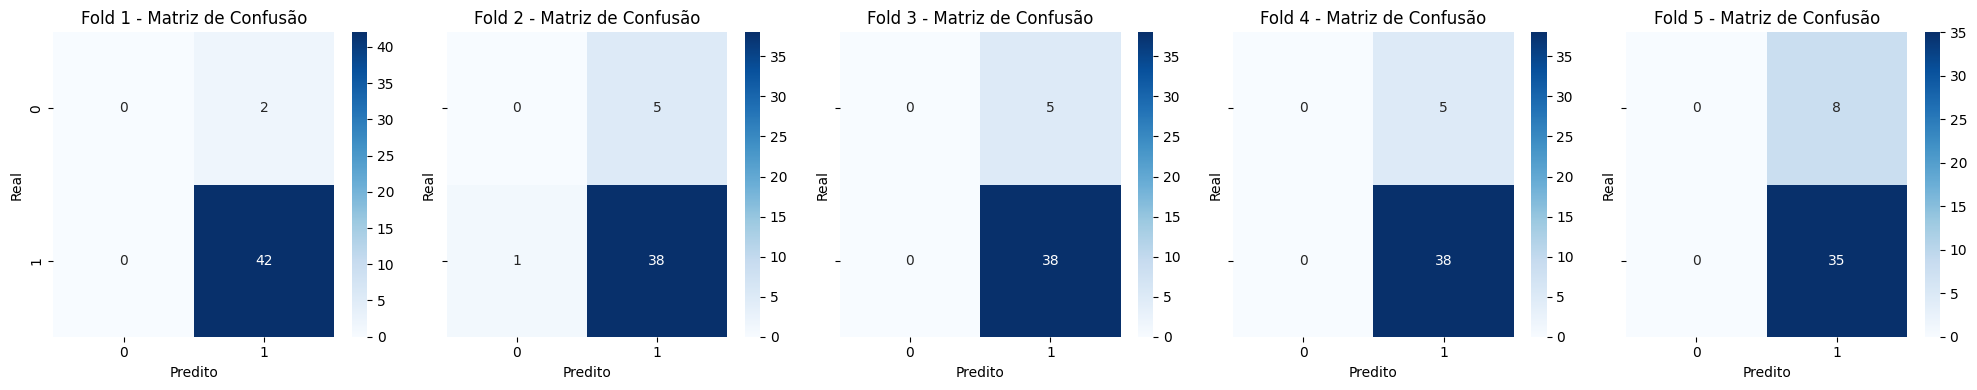

In [32]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4), sharey='row')
for i, conf_matrix in enumerate(conf_matrices):
    sns.heatmap(conf_matrix, annot=True, fmt="d", ax=axes[i], cmap="Blues")
    axes[i].set_title(f'Fold {i+1} - Matriz de Confusão')
    axes[i].set_xlabel('Predito')
    axes[i].set_ylabel('Real')

plt.tight_layout()
plt.show()

**Acurácia para cada fold**

In [33]:
for i, (train_index, test_index) in enumerate(skf.split(X_train, y_train)):
    #Pegando as predições para o fold atual
    fold_y_pred = y_pred[test_index]
    fold_y_true = y_train.iloc[test_index] 
    fold_accuracy = accuracy_score(fold_y_true, fold_y_pred)
    print(f'Acurácia do Fold {i+1}: {fold_accuracy:.5f}')


Acurácia do Fold 1: 0.88636
Acurácia do Fold 2: 0.86364
Acurácia do Fold 3: 0.90698
Acurácia do Fold 4: 0.90698
Acurácia do Fold 5: 0.90698


**Treinamento do Modelo**

In [34]:
# Treinando o modelo com os dados de treino. Aqui é onde a pipeline vai aplicar o OrdinalEncoder e GaussianNB.
pipeline.fit(X_train, y_train)

Pipeline(steps=[('encoder', OrdinalEncoder()), ('knn', KNeighborsClassifier())])

In [35]:
#VERIFICANDO SE É OU NÃO OVERFITTING

# Se a acurácia do conjunto de treinamento for significativamente maior que a do conjunto de teste, isso pode indicar overfitting.

#Acurácia alta no treino e baixa no teste: Indica overfitting.
#Acurácias próximas: Indica que o modelo está generalizando bem.

# Avaliação no conjunto de treinamento
train_accuracy = pipeline.score(X_train, y_train)
print("Acurácia no conjunto de treinamento: {:.2f}%".format(train_accuracy * 100))

# Avaliação no conjunto de teste
test_accuracy = pipeline.score(X_test, y_test)
print("Acurácia no conjunto de teste: {:.2f}%".format(test_accuracy * 100))

#Acurácia no conjunto de treinamento: 90.78%
#Acurácia no conjunto de teste: 90.91%

Acurácia no conjunto de treinamento: 90.78%
Acurácia no conjunto de teste: 90.91%


**Avaliação**

Matriz de Confusão:
 [[ 0  5]
 [ 0 50]]


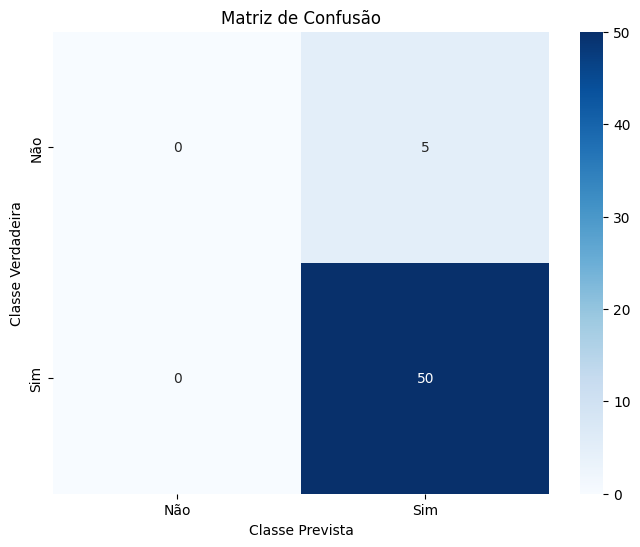

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.91      1.00      0.95        50

    accuracy                           0.91        55
   macro avg       0.45      0.50      0.48        55
weighted avg       0.83      0.91      0.87        55

Acurácia: 0.9090909090909091


C:\Users\talitanalon-ieg\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\talitanalon-ieg\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\talitanalon-ieg\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [36]:
# Testar o modelo no conjunto de teste
resultado = pipeline.predict(X_test)

matrix_conf = confusion_matrix(y_test, resultado)
print("Matriz de Confusão:\n", matrix_conf)

# Visualização da Matriz de Confusão
plt.figure(figsize=(8, 6))
sns.heatmap(matrix_conf, annot=True, fmt='d', cmap='Blues', xticklabels=['Não', 'Sim'], yticklabels=['Não', 'Sim'])
plt.ylabel('Classe Verdadeira')
plt.xlabel('Classe Prevista')
plt.title('Matriz de Confusão')
plt.show()

# Relatório de Classificação
print(classification_report(y_test, resultado))

# Acurácia
acuracia = accuracy_score(y_test, resultado)
print("Acurácia:", acuracia)

**Avaliação do Modelo no Conjunto de Teste**

In [37]:
# E ao final, avaliamos o modelo com conjunto de teste para ver a performance desse modelo em dados que não foram usados no treinamento
# Avaliando o modelo no conjunto de teste
test_accuracy = pipeline.score(X_test, y_test)
print("Acurácia no conjunto de teste: {:.2f}%".format(test_accuracy * 100))

Acurácia no conjunto de teste: 90.91%


In [ ]:
#joblib.dump(pipeline, 'pipeline_model.pkl')

#print("Modelo treinado e salvo com sucesso como #'pipeline_model.pkl'")

Modelo treinado e salvo com sucesso como 'pipeline_model.pkl'
